In [48]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [49]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

In [50]:
def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3] 
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    
    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path 

[*********************100%***********************]  1 of 1 completed


         Current function value: 391.522525
         Iterations: 3
         Function evaluations: 282
         Gradient evaluations: 55
RMSE value is: $ 2.298271379759527


/Users/lydia/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


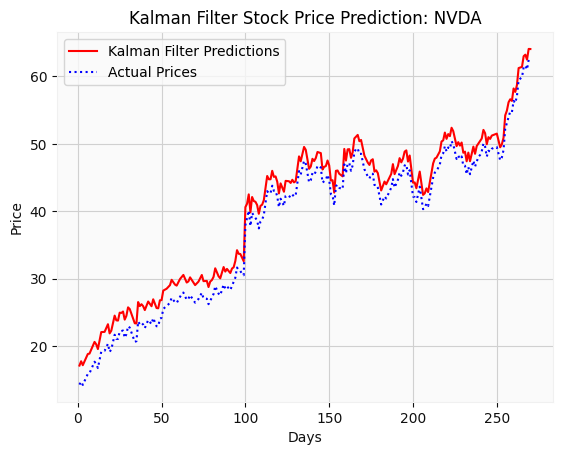

In [51]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'
stock = yf.download(stock_symbol, start=start_date, end=end_date)
Y = stock['Adj Close'].values
S = Y.shape[0]
param0 = np.array([1.05, 0.96, np.var(Y) / 200, np.var(Y) / 100])
results = minimize(kalman_filter, param0, method='BFGS', tol=1e-2, options={'disp': True})

# Smooth and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
sorted_path = dict(sorted(path.items()))
Y_kalmanFilter = sorted_path.values()

# Time vector for plotting
timevec = np.linspace(1, S, S)
plt.title('Kalman Filter Stock Price Prediction: ' + stock_symbol)
plt.plot(timevec, Y_kalmanFilter, 'r', label='Kalman Filter Predictions')
plt.plot(timevec, Y, 'b:', label='Actual Prices')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')

# Calculate RMSE
kalman_values = list(Y_kalmanFilter)
RMSE = np.sqrt(np.mean((np.array(kalman_values) - Y) ** 2))
print('RMSE value is: $', RMSE)

plt.show()

In [52]:
pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


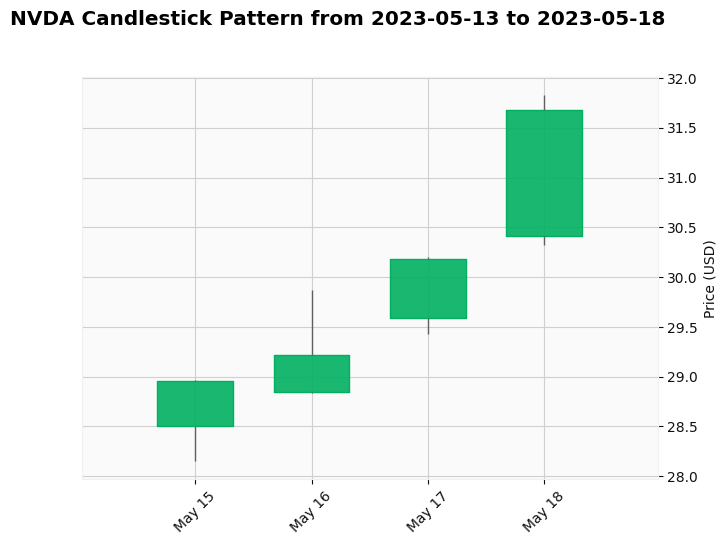

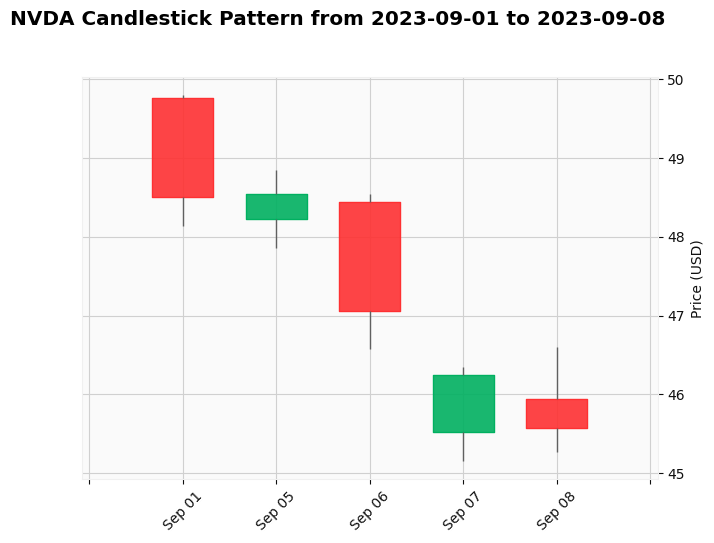

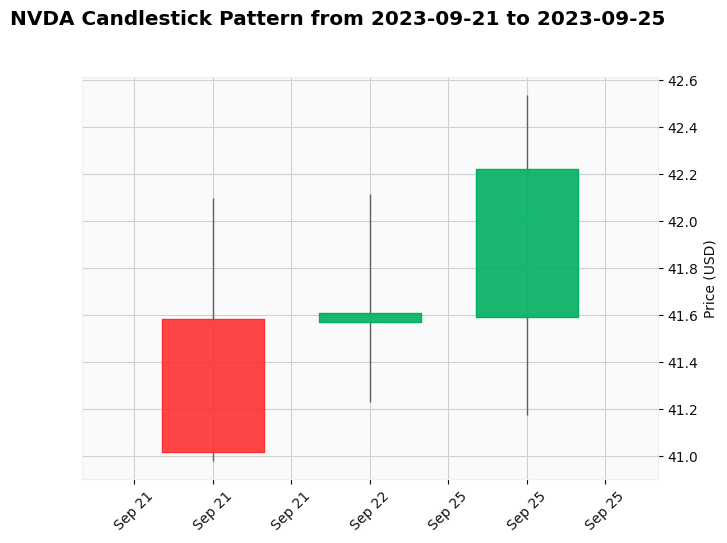

In [75]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import mplfinance as mpf

# Load NVDA stock data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'
stock = yf.download(stock_symbol, start=start_date, end=end_date)

# Define the approximate dates for the highlighted circles in the Kalman Filter chart
# Replace these dates with the specific ranges you want to highlight
highlighted_ranges = [
    ('2023-05-13', '2023-05-18'),  # Example date range for the first circle
    ('2023-09-01', '2023-09-08'),  # Example date range for the second circle
    ('2023-09-21', '2023-09-25'),  # Example date range for the third circle
    #('2024-09-11', '2023-09-14')   # Example date range for the fourth circle
]

# Plot candlestick patterns for each highlighted date range
for i, (start, end) in enumerate(highlighted_ranges):
    # Filter stock data for the date range
    date_range_data = stock.loc[start:end]

    # Plot the candlestick chart for the specified range
    mpf.plot(date_range_data, type='candle', style='yahoo',
             title=f"NVDA Candlestick Pattern from {start} to {end}",
             ylabel="Price (USD)")

    # Optionally, save each plot as an image for your presentation
    # mpf.plot(date_range_data, type='candle', style='yahoo',
    #          title=f"NVDA Candlestick Pattern from {start} to {end}",
    #          ylabel="Price (USD)", savefig=f"candlestick_{i+1}.png")
